In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

In [2]:
df = pd.read_excel('cleaned_dataset.xlsx')
# Shuffle the data
obesity_data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(obesity_data['Class'])

0       4
1       2
2       4
3       3
4       3
       ..
1605    3
1606    2
1607    2
1608    4
1609    3
Name: Class, Length: 1610, dtype: int64


In [3]:
# Ensure consistent reference to the DataFrame
transport_columns = [col for col in obesity_data.columns if 'Type_of_Transportation_Used_' in col]
transport_data = obesity_data[transport_columns]

# Aggregate transport columns into a single feature (e.g., summing)
transport_feature = transport_data.astype(int).sum(axis=1)

# Update the feature set X to include the new transport feature
X = obesity_data[['Sex', 'Age', 'Height', 'Overweight_Obese_Family', 
                  'Consumption_of_Fast_Food', 'Frequency_of_Consuming_Vegetables', 
                  'Number_of_Main_Meals_Daily', 'Food_Intake_Between_Meals', 'Smoking', 
                  'Liquid_Intake_Daily', 'Calculation_of_Calorie_Intake', 
                  'Physical_Excercise', 'Schedule_Dedicated_to_Technology']].copy()

X['Transport_Feature'] = transport_feature  # Add transport feature

# Target variable
y = obesity_data['Class']

# Print class distribution
print(y.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Class
2    658
3    592
4    287
1     73
Name: count, dtype: int64


In [4]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(y_test)

(1288, 14) (322, 14)
(1288,) (322,)
29      2
99      3
678     3
1399    3
185     3
       ..
617     2
629     4
1574    3
1323    2
948     2
Name: Class, Length: 322, dtype: int64


In [5]:
# Check the class distribution in the training set
print(y_train.value_counts())

Class
2    537
3    466
4    229
1     56
Name: count, dtype: int64


In [6]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

In [7]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [3, 5, 11], 
    'min_samples_leaf': [1, 2, 5]
}
rf_classifier = RandomForestClassifier(random_state=42)
# Define StratifiedKFold with random_state to control cross-validation randomness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', n_jobs=-1, refit=True, cv=cv, verbose=0)
grid_search.fit(X_resampled, y_resampled)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
# model evaluation

Best hyperparameters: {'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 200}


In [8]:
best_rf_classifier = grid_search.best_estimator_
accuracy = best_rf_classifier.score(X_test, y_test)
print("Accuracy with best hyperparameters:", accuracy)
#y_pred = best_rf_classifier.predict(X_test)

Accuracy with best hyperparameters: 0.8416149068322981


In [9]:
from sklearn.metrics import classification_report, accuracy_score
best_model = best_rf_classifier
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.59      0.67        17
           2       0.86      0.86      0.86       121
           3       0.83      0.87      0.85       126
           4       0.84      0.83      0.83        58

    accuracy                           0.84       322
   macro avg       0.83      0.79      0.80       322
weighted avg       0.84      0.84      0.84       322

Accuracy: 0.84


In [10]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.7851012495812422


In [11]:
feature_scores = pd.Series(best_rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

Physical_Excercise                   0.171921
Age                                  0.170174
Frequency_of_Consuming_Vegetables    0.104083
Number_of_Main_Meals_Daily           0.103513
Height                               0.091839
Liquid_Intake_Daily                  0.071662
Food_Intake_Between_Meals            0.059833
Schedule_Dedicated_to_Technology     0.051404
Sex                                  0.038495
Transport_Feature                    0.036245
Consumption_of_Fast_Food             0.032483
Smoking                              0.032135
Overweight_Obese_Family              0.018681
Calculation_of_Calorie_Intake        0.017533
dtype: float64

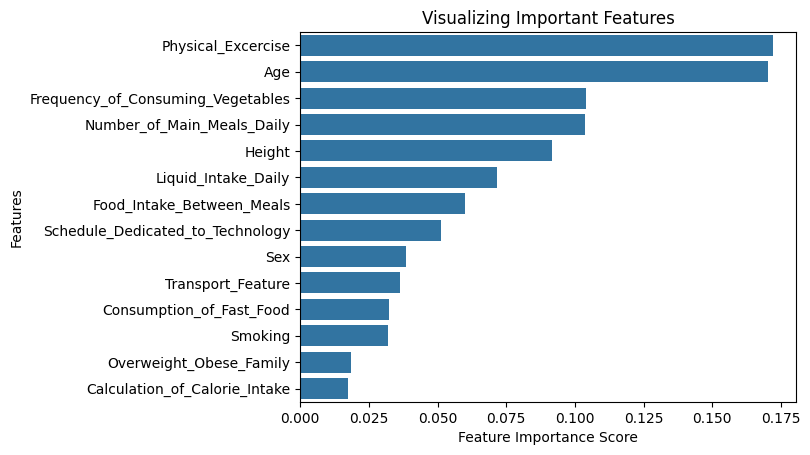

In [12]:
sns.barplot(x=feature_scores, y=feature_scores.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()